In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft
from scipy.stats import wasserstein_distance

In [95]:
'''from scipy import signal
x = np.arange(0, 250, 1)
y = np.zeros(250)
y[0:50] = 0
y[50:200] = signal.triang(150)
y[200:250] = 0
plt.plot(x, y)
plt.show()'''

'from scipy import signal\nx = np.arange(0, 250, 1)\ny = np.zeros(250)\ny[0:50] = 0\ny[50:200] = signal.triang(150)\ny[200:250] = 0\nplt.plot(x, y)\nplt.show()'

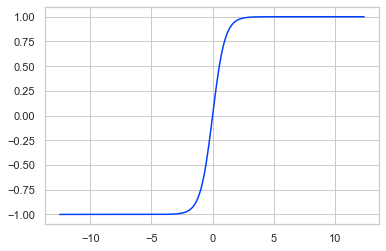

In [358]:
from scipy import signal
import math
x = np.arange(-12.5, 12.5, 0.1)
y = np.zeros(250)
y = np.tanh(x)
plt.plot(x, y)
plt.show()

In [359]:
#x = np.arange(1, 31, 1)
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [4]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [5]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(n_components=4) 

WEIGHTS - [0.2 0.2 0.3 0.3] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[2.45000000e+01 2.69342236e-14]
 [2.24500000e+02 2.69342236e-14]
 [8.70000000e+01 5.00000000e-01]
 [1.62000000e+02 5.00000000e-01]] 



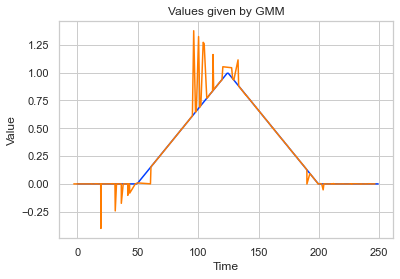

In [6]:
z,_ = best_gmm.sample(250)
plt.title('Actual data')
sns.lineplot(signal_3['Time'], signal_3['Value'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z[:,0],z[:,1])
plt.show()

In [49]:
wasserstein_distance(signal_3['Value'], z[:, 1])

0.031064409415122278

# GMM on abs FFT

In [4]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(np.abs(f[:N//2+1]),np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return fft_data

In [5]:
freq_ampli = freq(signal_3)

<AxesSubplot:xlabel='Freq', ylabel='Ampli'>

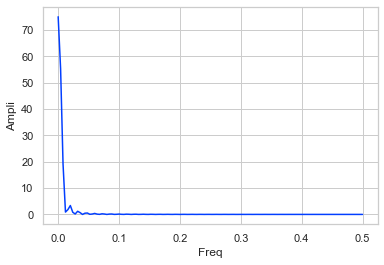

In [6]:
#plt.figure(figsize=(10,6))
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
#plt.xlim(-0.1, 0.1)

In [11]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm1 = GMM_fit(freq_ampli)

In [12]:
print(best_gmm1, '\n')
print('WEIGHTS -', best_gmm1.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm1.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=9) 

WEIGHTS - [0.37582314 0.00793651 0.00793651 0.00793651 0.00793651 0.34304364
 0.06279001 0.00793651 0.17866067] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[4.02096960e-01 1.76197525e-03]
 [0.00000000e+00 7.50000000e+01]
 [4.00000000e-03 5.52615252e+01]
 [8.00000000e-03 1.90908794e+01]
 [1.60000000e-02 1.82244031e+00]
 [2.25984376e-01 1.12713508e-02]
 [3.75265235e-02 6.41717253e-01]
 [2.00000000e-02 3.37514749e+00]
 [1.04236209e-01 7.87098656e-02]] 



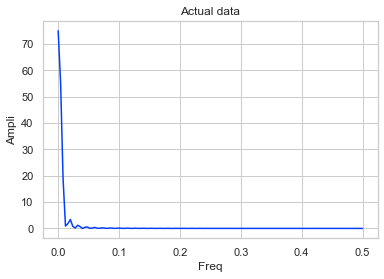

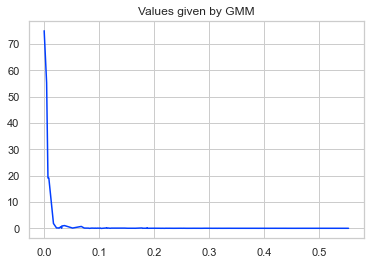

In [13]:
z2,_ = best_gmm1.sample(126)
plt.title('Actual data')
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
plt.show()
plt.title('Values given by GMM')
sns.lineplot(z2[:,0],z2[:,1])
plt.show()

In [51]:
wasserstein_distance(freq_ampli['Ampli'], z2[:, 1])

8.096282238570373

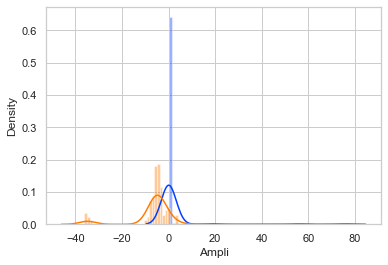

In [52]:
sns.distplot(freq_ampli['Ampli'], kde = True)
sns.distplot(z2[:, 1], kde = True)
#plt.ylim(0.0, 0.2)
plt.show()

# GMM on FFT of actual time series

In [360]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

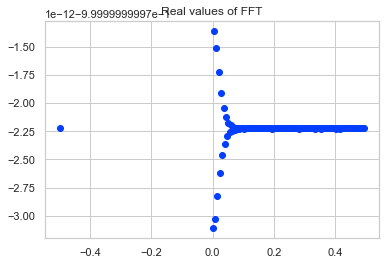

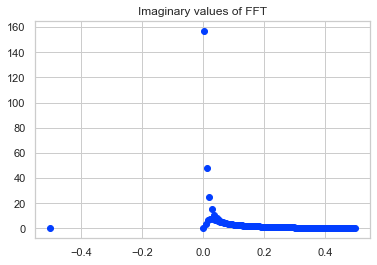

In [361]:
plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

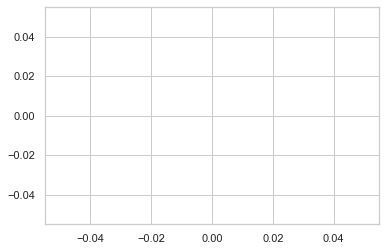

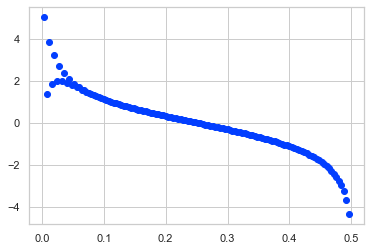

In [362]:
freq_ampli3['Ampli'] = np.log(freq_ampli3["Ampli"])
freq_ampli3 = freq_ampli3.loc[freq_ampli3['Ampli'] != float('-inf')]
freq_ampli3 = freq_ampli3.dropna()
plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.show()
freq_ampli3i['Ampli'] = np.log(freq_ampli3i["Ampli"])
freq_ampli3i = freq_ampli3i.loc[freq_ampli3i['Ampli'] != float('-inf')]
freq_ampli3i = freq_ampli3i.dropna()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.show()

In [363]:
print(np.shape(freq_ampli3))
print(np.shape(freq_ampli3i))

(0, 2)
(124, 2)


In [303]:
dfx = freq_ampli3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 26)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm0 = gmm

In [388]:
dfx = freq_ampli3i
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm0i = gmm                    

In [305]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(n_components=4) 

WEIGHTS - [0.73928913 0.03773585 0.10677646 0.11619856] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.49569031e-01  2.01573445e+00]
 [ 2.50000000e-01 -3.33212465e+01]
 [ 4.71954321e-01 -7.67086068e-01]
 [ 2.44285838e-02  4.88491675e+00]] 



In [391]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=9) 

WEIGHTS - [0.1473763  0.12841445 0.34881266 0.03205437 0.10514142 0.06513934
 0.04512078 0.11987617 0.00806452] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 3.76932226e-01 -9.12195123e-01]
 [ 7.49487482e-02  1.44145205e+00]
 [ 2.53894506e-01 -2.57571970e-02]
 [ 2.39712426e-02  3.04143876e+00]
 [ 4.39580710e-01 -1.68211681e+00]
 [ 4.81811218e-01 -3.04095476e+00]
 [ 2.95805055e-02  1.84178663e+00]
 [ 1.37847762e-01  7.78477533e-01]
 [ 4.00000000e-03  5.05701396e+00]] 



In [407]:
#Sampling
#z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

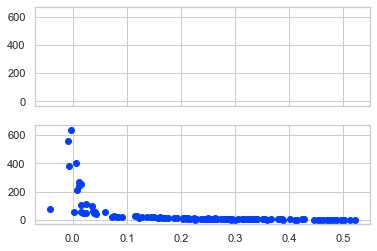

In [393]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()

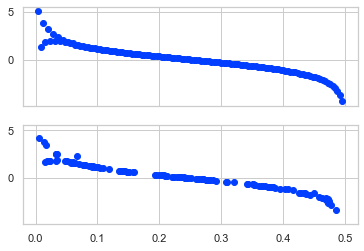

In [408]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [409]:
#print('Real: ', wasserstein_distance(freq_ampli3['Ampli'], z1[:, 1]))
#print('Imag: ', wasserstein_distance(freq_ampli3i['Ampli'], z1i[:, 1]))

In [410]:
#z1[:, 1] = np.exp(z1[:, 1])
z1i[:, 1] = np.exp(z1i[:, 1])

In [411]:
#sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [412]:
#sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
#sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [413]:
#sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
#sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [414]:
f = fftpack.fftfreq(250)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [415]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [416]:
#sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [417]:
#samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [353]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

{0.0: 0.0,
 0.004: 0.0,
 0.008: 213.1403505421271,
 0.012: 271.17754684121115,
 0.016: 257.06348723190644,
 0.02: 46.54992788594662,
 0.024: 46.719873722021646,
 0.028: 0.0,
 0.032: 0.0,
 0.036: 95.53888154004274,
 0.04: 47.36918916591522,
 0.044: 0.0,
 0.048: 0.0,
 0.052: 0.0,
 0.056: 0.0,
 0.06: 54.679213556395084,
 0.064: 0.0,
 0.068: 0.0,
 0.072: 23.03694781592526,
 0.076: 29.508140547179174,
 0.08: 0.0,
 0.084: 22.272667194518718,
 0.088: 0.0,
 0.092: 18.95850651440909,
 0.096: 0.0,
 0.1: 0.0,
 0.104: 0.0,
 0.108: 0.0,
 0.112: 0.0,
 0.116: 25.29301634579726,
 0.12: 25.37726531119852,
 0.124: 11.431993561551218,
 0.128: 20.09204231777283,
 0.132: 0.0,
 0.136: 22.218926326288674,
 0.14: 0.0,
 0.144: 0.0,
 0.148: 20.68774566481395,
 0.152: 19.10743574566015,
 0.156: 0.0,
 0.16: 17.381236082007888,
 0.164: 0.0,
 0.168: 9.99115993884589,
 0.172: 0.0,
 0.176: 10.9246052660465,
 0.18: 0.0,
 0.184: 0.0,
 0.188: 12.001215976442406,
 0.192: 11.339295526375176,
 0.196: 0.0,
 0.2: 0.0,
 0.204

In [418]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.004: 68.0862723579179j,
 0.008: 0.0,
 0.012: 46.233208977696336j,
 0.016: 37.48720343276628j,
 0.02: 0.0,
 0.024: 6.2450849493924245j,
 0.028: 0.0,
 0.032: 12.440499499599328j,
 0.036: 0.0,
 0.04: 0.0,
 0.044: 0.0,
 0.048: 5.96939382149701j,
 0.052: 5.746107675710148j,
 0.056: 10.201293499972373j,
 0.06: 10.22115588523074j,
 0.064: 4.856020187035788j,
 0.068: 0.0,
 0.072: 0.0,
 0.076: 4.1297664228843605j,
 0.08: 3.955123737370758j,
 0.084: 0.0,
 0.088: 3.5614104521783005j,
 0.092: 6.778888077728834j,
 0.096: 3.214207192778683j,
 0.1: 3.0840533968899755j,
 0.104: 2.8480884102544253j,
 0.108: 2.791570668967313j,
 0.112: 0.0,
 0.116: 0.0,
 0.12: 2.567138166898134j,
 0.124: 0.0,
 0.128: 0.0,
 0.132: 0.0,
 0.136: 4.427538791586951j,
 0.14: 2.1326921568050703j,
 0.144: 2.0553302184193667j,
 0.148: 3.940788949021221j,
 0.152: 1.9416170283724532j,
 0.156: 1.8219855877911943j,
 0.16: 1.8059797552686436j,
 0.164: 0.0,
 0.168: 0.0,
 0.172: 0.0,
 0.176: 0.0,
 0.18: 0.0,
 0.184: 0.0,


In [419]:
value = list(sd.values())

# Final IFFT 

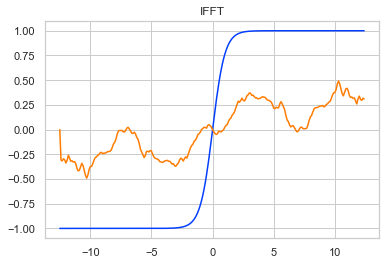

In [420]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)

# Log freq

In [357]:
log_ampli = np.log(freq_ampli["Ampli"])
log_freq_ampli= pd.DataFrame(zip(freq_ampli['Freq'],log_ampli),columns=['Freq','Ampli'])
log_freq_ampli = log_freq_ampli.loc[log_freq_ampli['Ampli'] != float('-inf')]
plt.scatter(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])

NameError: name 'freq_ampli' is not defined

In [ ]:
log_freq_ampli.describe()

In [ ]:
dfx = log_freq_ampli
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm2 = gmm

In [ ]:
print(best_gmm2, '\n')
print('WEIGHTS -', best_gmm2.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm2.means_, '\n')

In [ ]:
z2,_ = best_gmm2.sample(125)
plt.title('Actual data')
plt.scatter(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])
plt.show()
plt.title('Values given by GMM')
plt.scatter(z2[:,0],z2[:,1])
plt.show()

In [ ]:
wasserstein_distance(log_freq_ampli['Ampli'], z2[:, 1])

In [ ]:
sns.distplot(log_freq_ampli['Ampli'], kde = True)
sns.distplot(z2[:, 1], kde = True)
#plt.ylim(0.0, 0.2)
plt.show()

In [ ]:
def dim(df):
    d = []
    for i,j in df.values.tolist():
        for k in range(round(j)):
            d.append(i)
    return d
list(np.array(log_freq_ampli))
fre = dim(log_freq_ampli)
log_freq_ampli.sort_values(by=['Ampli'],ascending = False)
np.shape(fre)

In [ ]:
plt.scatter(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])
plt.show()
sns.distplot(fre)

In [ ]:
fre = np.array(fre).reshape(-1,1)
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm11 = GMM_fit(fre)

In [ ]:
print(best_gmm11, '\n')
print('WEIGHTS -', best_gmm11.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm11.means_, '\n')

In [ ]:
z11,_ = best_gmm11.sample(13)
plt.title('Actual data')
sns.distplot(fre)
#plt.show()
plt.title('Values given by GMM')
sns.distplot(z11)
plt.show()

In [ ]:
wasserstein_distance(fre.flatten(), z11.flatten())

# Cepstrum

In [ ]:
frame_size = signal_3.shape[0]
Fs = 1
dt = 1/Fs
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
y = np.array(signal_3['Value'])
yf = fftpack.fft(y)
yf1 = yf[yf != 0]
quefrency = np.fft.rfftfreq(np.log(yf1).size,freq_vector[1] - freq_vector[0])
cepstrum = np.fft.rfft(np.log(np.abs(yf1)))
cep = pd.DataFrame(zip(quefrency,cepstrum.real),columns=['Quefrency','Cepstrum'])
cep = cep.iloc[1:,:]
plt.scatter(cep.Quefrency,cep.Cepstrum)

In [ ]:
dfx = cep
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm3 = gmm

In [ ]:
print(best_gmm3, '\n')
print('WEIGHTS -', best_gmm3.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm3.means_, '\n')

In [ ]:
z3,_ = best_gmm3.sample(125)
plt.title('Actual data')
plt.scatter(cep['Quefrency'], cep['Cepstrum'])
plt.show()
plt.title('Values given by GMM')
plt.scatter(z3[:,0],z3[:,1])
plt.show()

In [ ]:
wasserstein_distance(cep['Cepstrum'], z3[:, 1])

In [ ]:
def dim(df):
    d = []
    for i,j in df.values.tolist():
        for k in range(round(j)):
            d.append(i)
    return d
list(np.array(cep))
c = dim(cep)
cep.sort_values(by=['Cepstrum'],ascending = False)
np.shape(c)

In [ ]:
plt.scatter(cep['Quefrency'], cep['Cepstrum'])
plt.show()
sns.distplot(c)

In [ ]:
c = np.array(c).reshape(-1,1)
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 100)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm22 = GMM_fit(c)

In [ ]:
print(best_gmm22, '\n')
print('WEIGHTS -', best_gmm22.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm22.means_, '\n')

In [ ]:
z22,_ = best_gmm22.sample(5851)
plt.title('Actual data')
sns.distplot(c)
#plt.show()
plt.title('Values given by GMM')
sns.distplot(z22)
plt.show()

In [ ]:
wasserstein_distance(c.flatten(), z22.flatten())